In [ ]:
import numpy as np
import sparse
import random
import matplotlib.pyplot as plt
# plt.rcParams['text.usetex'] = False


from sparse_circuit import *

from tqdm import tqdm
import pickle

def extract_value(d_list, key):
    return [d[key] for d in d_list]

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

# 1. Fidelity Scaling with depth (paths kept)
Here we show some results of how fidelity scales with path depth $d=N/D$, where N is the number of Feyman Paths kept at each culling portion, and $D=2^n$, with n being the number of qbits. We run 2 results, one with a small number (12) of qbits, and another with a larger number (18) qbits. For density of results, both tests are run from $N = 5$ to $N = max(D, 10000)$, with 200 total points. The circuit architecture is Haar-random 2-qbit gates applied across layers in which wires are randomly paired

## 1.1 12 qbits

In [ ]:
# circuit parameters
n_qbits = 12
n_layers = 12

# construct wires and gates 
wires = np.concatenate([
    construct_random_wire_list(n_qbits) for _ in range(n_layers)
])
gates = [haar_2qbit(sparse_type='coo') for _ in wires]

#run parameters
min_paths = 100
max_paths = 10000
n_path_vals = 100
D_list = np.linspace(min_paths, min(2**n_qbits, max_paths), n_path_vals, dtype=int)


#create list of functions, only used with 
fns_list = [
    [(trim_n_coo(n), 1), (norm_state, 1)]
    for n in D_list
]

#define circuit
zero_state_coo = zero_bitstring_coo(n_qbits)
circuit_coo = quantum_circuit(n_qbits, gates=gates, wires=wires)

# compute_fidelities
[fidelities] = compute_circuit_metrics(circuit_coo, fns_list, input_state=zero_state_coo, metric_fns=[compute_state_fidelity])

# Save to file
save_run_data('results_paper/12_qbit_base.pkl', n_qbits=circuit_coo.n_qbits, n_gates=len(circuit_coo.gates), n_paths=D_list, fidelities=fidelities)

In [ ]:
run1_data = load_run_data('results_paper/12_qbit_base.pkl')
fidelity = run1_data["fidelities"]
n_paths = run1_data["n_paths"]
n_gates = run1_data["n_gates"]

fig, ax = plt.subplots()
# ax.set_yscale("log")
depth = n_paths/(4**run1_data["n_gates"])
cull_frac = n_paths/2**run1_data['n_qbits']
plt.scatter(cull_frac, fidelity)
# plt.scatter(cull_frac, fidelity2)

plt.plot(cull_frac, cull_frac, c='red')
# plt.plot(depth, depth*2**12/4**72)

ax.set_xlabel("Fractional path depth d")
ax.set_ylabel("Fidelity")
ax.set_xscale("log")
ax.set_yscale("log")

plt.title(f"{run1_data["n_qbits"]} qbits and {n_gates} gates")

## 1.2 15 qubits

In [ ]:
# circuit parameters
n_qbits = 15
n_layers = 15

# construct wires and gates 
wires = np.concatenate([
    construct_random_wire_list(n_qbits) for _ in range(n_layers)
])
gates = [haar_2qbit(sparse_type='coo') for _ in wires]

#run parameters
min_paths = 100
max_paths = 10000
n_path_vals = 100
D_list = np.linspace(min_paths, min(2**n_qbits, max_paths), n_path_vals, dtype=int)


#create list of functions, only used with 
fns_list = [
    [(trim_n_coo(n), 1), (norm_state, 1)]
    for n in D_list
]

#define circuit
zero_state_coo = zero_bitstring_coo(n_qbits)
circuit_coo = quantum_circuit(n_qbits, gates=gates, wires=wires)

# compute_fidelities
[fidelities] = compute_circuit_metrics(circuit_coo, fns_list, input_state=zero_state_coo, metric_fns=[compute_state_fidelity])

# Save to file
save_run_data('results_paper/15_qbit_base.pkl', n_qbits=circuit_coo.n_qbits, n_gates=len(circuit_coo.gates), n_paths=D_list, fidelities=fidelities)

In [ ]:
run1_data = load_run_data('results_paper/15_qbit_base.pkl')
fidelity = run1_data["fidelities"]
n_paths = run1_data["n_paths"]
n_gates = run1_data["n_gates"]

fig, ax = plt.subplots()
# ax.set_yscale("log")
depth = n_paths/(4**run1_data["n_gates"])
cull_frac = n_paths/2**run1_data['n_qbits']
plt.scatter(cull_frac, fidelity)
# plt.scatter(cull_frac, fidelity2)

plt.plot(cull_frac, cull_frac, c='red')
# plt.plot(depth, depth*2**12/4**72)

ax.set_xlabel("Fractional path depth d")
ax.set_ylabel("Fidelity")
ax.set_xscale("log")
ax.set_yscale("log")

plt.title(f"{run1_data["n_qbits"]} qbits and {n_gates} gates")

## 1.3 18 qubits

In [ ]:
# circuit parameters
n_qbits = 18
n_layers = 18

###
### get full dense output for comparison
###

# construct wires and gates 
wires = np.concatenate([
    construct_random_wire_list(n_qbits) for _ in range(n_layers)
])

# construct gates and sparse counterparts
gates_dense = [haar_2qbit() for _ in wires]

#define dense circuit to compute expected output
circuit_dense = quantum_circuit(n_qbits, gates=gates_dense, wires=wires)

# zero input state
zero_state_dense = zero_bitstring_np(n_qbits)

# contract circuit to compute output
output_full = circuit_dense.contract(zero_state_dense)

###
### Sparse approximate circuit
###


#run parameters
min_paths = 100
max_paths = 10000
n_path_vals = 100
D_list = np.linspace(min_paths, min(2**n_qbits, max_paths), n_path_vals, dtype=int)

#sparse gates
gates_sparse = [convert_gate_to_coo(g) for g in gates_dense]

#create list of functions, only used with 
fns_list = [
    [(trim_n_coo(n), 1), (norm_state, 1)]
    for n in D_list
]

#define circuit
zero_state_coo = zero_bitstring_coo(n_qbits)
circuit_coo = quantum_circuit(n_qbits, gates=gates_sparse, wires=wires)

# compute_fidelities
fidelities = compute_fidelity_multi(circuit_coo, fns_list, input_state=zero_state_coo, expected_output=output_full)

# Save to file
save_run_data('results_paper/18_qbit_base.pkl', n_qbits=circuit_coo.n_qbits, n_gates=len(circuit_coo.gates), n_paths=D_list, fidelities=fidelities)

In [ ]:
run1_data = load_run_data('results_paper/18_qbit_base.pkl')
fidelity = run1_data["fidelities"]
n_paths = run1_data["n_paths"]

fig, ax = plt.subplots()
ax.set_yscale("log")
ax.set_xscale("log")
depth = n_paths/(2**run1_data["n_qbits"])
plt.scatter(depth, fidelity)
plt.plot(depth, depth, c='orange')

ax.set_xlabel("Fractional path depth d")
ax.set_ylabel("Fidelity")
plt.title(f"{run1_data["n_qbits"]} qbits and {run1_data["n_gates"]} gates")

## Plotting all data

In [ ]:
data12 = load_run_data('results_paper/12_qbit_base.pkl')
data15 = load_run_data('results_paper/15_qbit_base.pkl')
data18 = load_run_data('results_paper/18_qbit_base.pkl')

d12, fid12 = data12['n_paths']/2**data12['n_qbits'], data12['fidelities']
d15, fid15 = data15['n_paths']/2**data15['n_qbits'], data15['fidelities']
d18, fid18 = data18['n_paths']/2**data18['n_qbits'], data18['fidelities']

fig, ax = plt.subplots()
ax.scatter(d12, fid12, c='chartreuse', s=20, label='12 qubits')
ax.scatter(d15, fid15, c='lightcoral', s=20, label='15 qubits')
ax.scatter(d18, fid18, c='cyan', s=20, label='18 qubits')

# ax.plot([1e-4, 1], [1e-4, 1],  c="blue") #slope 1 line for ref
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Fractional Path Depth d')
ax.set_ylabel('Final State Fidelity')
ax.set_title('Fidelity vs fractional path depth')

# 2. Plotting vs total probability kept

In [ ]:
#circuit parameters
n_qbits = 12
n_layers = 2

min_paths = 10
max_paths = min(10000, 2**n_qbits)
n_paths_list = np.linspace(min_paths, max_paths, 150, dtype=int)

wires = np.concatenate([construct_random_wire_list(n_qbits) for _ in range(n_layers)])
gates = [haar_2qbit(sparse_type='coo') for _ in wires]

#circuit definition
circuit = quantum_circuit(n_qbits, gates, wires)
state0 = zero_bitstring_coo(n_qbits)

#cull funtions lowest
fns_list_lowest = [
    [(trim_n_coo(n),1)] for n in n_paths_list 
]

fns_list_random = [
    [(trim_n_random_coo(n),1)] for n in n_paths_list 
]

In [ ]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_lowest,
                                                                 metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data('results_paper/shallow_12qbit_lowest.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

In [ ]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_random,
                                                                 metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data('results_paper/shallow_12qbit_random.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

In [ ]:
data_lowest = load_run_data('results_paper/shallow_12qbit_lowest.pkl')
data_random = load_run_data('results_paper/shallow_12qbit_random.pkl')

P_lowest = data_lowest['total_probability']
P_random = data_random['total_probability']
f_lowest = data_lowest['fidelity']
f_random = data_random['fidelity']

n_qbits = data_lowest['n_qbits']
n_vals = data_lowest['n_kept']
n_layers = data_lowest['n_layers']


fig, ax = plt.subplots()

ax.scatter(P_lowest, f_lowest, label='lowest-value culling')
ax.scatter(P_random, f_random, label='random culling')

ax.set_xlabel('Total Probability Kept, $P_t$')
ax.set_ylabel('Final State Fidelity, $f$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(f'{n_qbits} Qubits, {n_layers} Layers')
ax.legend()
#plot slope 1`

ax.plot(P_random, P_random+1/2**n_qbits, c='red')

# total_probability_kept

In [ ]:
fig, ax = plt.subplots()
f_kept = n_vals/2**n_qbits
ax.scatter(f_kept, f_lowest, label='lowest-value culling')
ax.scatter(f_kept, f_random, label='random culling')


ax.set_xlabel('Iterative Fraction Kept, $F_{kept}$')
ax.set_ylabel('Final state fidelity, $f$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(f'{n_qbits} Qubits, {n_layers} Layers')
ax.legend()

# 3. Comparing results vs Gate Number

In [46]:
n_qbits = 24

## 3.1 1 Layer

In [47]:
#circuit parameters
n_layers = 1

min_paths = np.log10(10)
max_paths = np.log10(min(25000, 2**n_qbits))
n_paths_list = np.logspace(min_paths, max_paths, 50, dtype=int)

wires = np.concatenate([construct_random_wire_list(n_qbits) for _ in range(n_layers)])
gates = [haar_2qbit(sparse_type='coo') for _ in wires]

#circuit definition
circuit = quantum_circuit(n_qbits, gates, wires)
state0 = zero_bitstring_coo(n_qbits)

#cull funtions lowest
fns_list_lowest = [
    [(trim_n_coo(n),1)] for n in n_paths_list 
]

fns_list_random = [
    [(trim_n_random_coo(n),1)] for n in n_paths_list 
]

In [48]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_lowest,
                                                                 metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data(f'results_paper/{n_qbits}qbit_{n_layers}layer_lowest.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


In [49]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_random,
                                                                 metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data(f'results_paper/{n_qbits}qbit_{n_layers}layer_random.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

100%|██████████| 50/50 [00:10<00:00,  4.68it/s]


## 3.2 3 Layers

In [50]:
#circuit parameters
n_layers = 3

min_paths = np.log10(10)
max_paths = np.log10(min(25000, 2**n_qbits))
n_paths_list = np.logspace(min_paths, max_paths, 50, dtype=int)

wires = np.concatenate([construct_random_wire_list(n_qbits) for _ in range(n_layers)])
gates = [haar_2qbit(sparse_type='coo') for _ in wires]

#circuit definition
circuit = quantum_circuit(n_qbits, gates, wires)
state0 = zero_bitstring_coo(n_qbits)

#cull funtions lowest
fns_list_lowest = [
    [(trim_n_coo(n),1)] for n in n_paths_list 
]

fns_list_random = [
    [(trim_n_random_coo(n),1)] for n in n_paths_list 
]

In [51]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_lowest,
                                                                 metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data(f'results_paper/{n_qbits}qbit_{n_layers}layer_lowest.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


In [52]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_random,
                                                                 metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data(f'results_paper/{n_qbits}qbit_{n_layers}layer_random.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


# 3.3 5 Layers

In [53]:
#circuit parameters
n_layers = 5

min_paths = np.log10(10)
max_paths = np.log10(min(25000, 2**n_qbits))
n_paths_list = np.logspace(min_paths, max_paths, 50, dtype=int)

wires = np.concatenate([construct_random_wire_list(n_qbits) for _ in range(n_layers)])
gates = [haar_2qbit(sparse_type='coo') for _ in wires]

#circuit definition
circuit = quantum_circuit(n_qbits, gates, wires)
state0 = zero_bitstring_coo(n_qbits)

#cull funtions lowest
fns_list_lowest = [
    [(trim_n_coo(n),1)] for n in n_paths_list 
]

fns_list_random = [
    [(trim_n_random_coo(n),1)] for n in n_paths_list 
]

In [54]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_lowest,
                                                                 metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data(f'results_paper/{n_qbits}qbit_{n_layers}layer_lowest.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


In [55]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_random,
                                                                 metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data(f'results_paper/{n_qbits}qbit_{n_layers}layer_random.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


# 3.4 10 Layers

In [56]:
#circuit parameters
n_layers = 10

min_paths = np.log10(10)
max_paths = np.log10(min(25000, 2**n_qbits))
n_paths_list = np.logspace(min_paths, max_paths, 50, dtype=int)

wires = np.concatenate([construct_random_wire_list(n_qbits) for _ in range(n_layers)])
gates = [haar_2qbit(sparse_type='coo') for _ in wires]

#circuit definition
circuit = quantum_circuit(n_qbits, gates, wires)
state0 = zero_bitstring_coo(n_qbits)

#cull funtions lowest
fns_list_lowest = [
    [(trim_n_coo(n),1)] for n in n_paths_list 
]

fns_list_random = [
    [(trim_n_random_coo(n),1)] for n in n_paths_list 
]

In [57]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_lowest,
                                                                 metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data(f'results_paper/{n_qbits}qbit_{n_layers}layer_lowest.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

100%|██████████| 50/50 [01:02<00:00,  1.26s/it]


In [58]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_random,
                                                    metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data(f'results_paper/{n_qbits}qbit_{n_layers}layer_random.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


## Plotting
Adjust the files imported to change which data are plotted

In [59]:
def extract_value(d_list, key):
    return [d[key] for d in d_list]

# random_marker = plt.
with plt.style.context('tableau-colorblind10'):
    my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

random_params = {'marker':'^', 'facecolors':'none', 's':30}
lowest_params = {'marker':'o', 'facecolors':'none', 's':10}
params1 = {'color': my_colors[0]}
params5 = {'color':my_colors[1]}
params10 = {'color':my_colors[2]} 

d1_low = load_run_data('results_paper/24qbit_1layer_lowest.pkl')
d3_low = load_run_data('results_paper/24qbit_3layer_lowest.pkl')
d5_low = load_run_data('results_paper/24qbit_5layer_lowest.pkl')
d1_rand = load_run_data('results_paper/24qbit_1layer_random.pkl')
d3_rand = load_run_data('results_paper/24qbit_3layer_random.pkl')
d5_rand = load_run_data('results_paper/24qbit_5layer_random.pkl')

d_list = [d1_low, d3_low, d5_low, d1_rand, d3_rand, d5_rand]

n_qbits = d1_low['n_qbits']
fidelities = extract_value(d_list, 'fidelity')
probs = extract_value(d_list, 'total_probability')
n_list = extract_value(d_list, 'n_kept')
cull_pct_list = [n/2**n_qbits for n in n_list]

Text(0.5, 1.0, 'Final State Fidelity for 24 Qubits and 12 gates per layer')

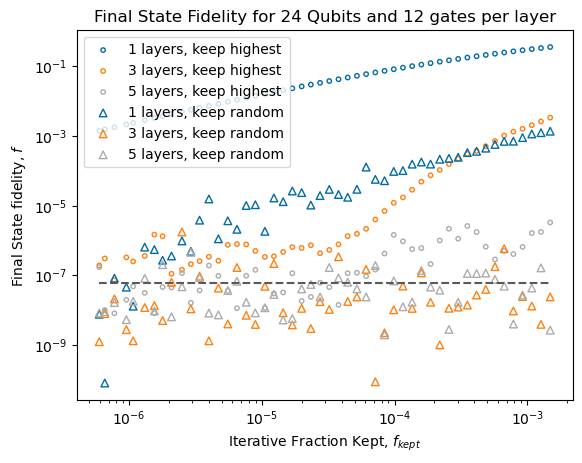

In [60]:
fig, ax = plt.subplots()
ax.scatter(cull_pct_list[0], fidelities[0], label='1 layers, keep highest', **lowest_params, **params1)
ax.scatter(cull_pct_list[1], fidelities[1], label='3 layers, keep highest', **lowest_params, **params5)
ax.scatter(cull_pct_list[2], fidelities[2], label='5 layers, keep highest', **lowest_params, **params10)
ax.scatter(cull_pct_list[3], fidelities[3], label='1 layers, keep random', **random_params, **params1)
ax.scatter(cull_pct_list[4], fidelities[4], label='3 layers, keep random', **random_params, **params5)
ax.scatter(cull_pct_list[5], fidelities[5], label='5 layers, keep random', **random_params, **params10)

ax.plot(cull_pct_list[0], 1/2**n_qbits*np.ones_like(cull_pct_list[0]), c=my_colors[3], linestyle='--')

ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Iterative Fraction Kept, $f_{kept}$')
ax.set_ylabel('Final State fidelity, $f$')
ax.set_title(f'Final State Fidelity for {n_qbits} Qubits and {int(n_qbits/2)} gates per layer')


In [ ]:
fig, ax = plt.subplots(figsize=2*cm*np.array((8.6,8.6)))
ax.scatter(probs[0], fidelities[0], label='1 qubit, keep highest', **lowest_params, **params1)
ax.scatter(probs[1], fidelities[1], label='3 qubit, keep highest', **lowest_params, **params5)
ax.scatter(probs[2], fidelities[2], label='5 qubit, keep highest', **lowest_params, **params10)
ax.scatter(probs[3], fidelities[3], label='1 qubit, keep random', **random_params, **params1)
ax.scatter(probs[4], fidelities[4], label='3 qubit, keep random', **random_params, **params5)
ax.scatter(probs[5], fidelities[5], label='5 qubit, keep random', **random_params, **params10)

probs_all = np.sort(np.concatenate(probs))
probs_range = np.linspace(np.min(probs_all), np.max(probs_all))

ax.plot(probs_all[105:], probs_all[105:], c=my_colors[3], linestyle='--')
ax.plot(probs_all, np.ones_like(probs_all)*1/2**n_qbits, c=my_colors[3], linestyle='--')


ax.legend()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Final Total Probability Mass (wip name), $p_{k}$')
ax.set_ylabel('Final State fidelity, $f$')
# ax.set_title(f'Final State Fidelity for {n_qbits} Qubits and {int(n_qbits/2)} gates per layer')

## Plotting all data

In [ ]:
with plt.style.context('tableau-colorblind10'):
    my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

random_params = {'marker':'^', 'facecolors':'none', 's':10}
lowest_params = {'marker':'o', 'facecolors':'none', 's':5}
params1 = {'color': my_colors[0]}
params5 = {'color':my_colors[1]}
params10 = {'color':my_colors[2]} 

w =6.5
extra_args = dict(figsize=[w, 1.5*w], dpi=300)
fig, axs = plt.subplots(2,1, **extra_args)#, sharex=True, sharey=True)

#15 qubits
d1_15_low= load_run_data('results_paper/15qbit_1layer_lowest.pkl')
d2_15_low = load_run_data('results_paper/15qbit_5layer_lowest.pkl')
d3_15_low = load_run_data('results_paper/15qbit_10layer_lowest.pkl')
d1_15_rand= load_run_data('results_paper/15qbit_1layer_random.pkl')
d2_15_rand = load_run_data('results_paper/15qbit_5layer_random.pkl')
d3_15_rand = load_run_data('results_paper/15qbit_10layer_random.pkl')

# 24 qubits
d1_24_low = load_run_data('results_paper/24qbit_1layer_lowest.pkl')
d2_24_low = load_run_data('results_paper/24qbit_3layer_lowest.pkl')
d3_24_low = load_run_data('results_paper/24qbit_5layer_lowest.pkl')
d1_24_rand = load_run_data('results_paper/24qbit_1layer_random.pkl')
d2_24_rand = load_run_data('results_paper/24qbit_3layer_random.pkl')
d3_24_rand = load_run_data('results_paper/24qbit_5layer_random.pkl')

#lists for unpacking
d_15_list = [d1_15_low, d2_15_low, d3_15_low , d1_15_rand, d2_15_rand, d3_15_rand]
d_24_list = [d1_24_low, d2_24_low, d3_24_low , d1_24_rand, d2_24_rand, d3_24_rand]

# extract data
n_qbits15 = 15
n_qbits24 = 24

fidelities15 = extract_value(d_15_list, 'fidelity')
probs15 = extract_value(d_15_list, 'total_probability')
n_list15 = extract_value(d_15_list, 'n_kept')
cull_pct_list15 = [n/2**n_qbits15 for n in n_list15]

fidelities24 = extract_value(d_24_list, 'fidelity')
probs24 = extract_value(d_24_list, 'total_probability')
n_list24 = extract_value(d_24_list, 'n_kept')
cull_pct_list24 = [n/2**n_qbits24 for n in n_list24]

probs_all = np.sort(np.concatenate(probs24))

# ax 0
# axs[0,0].scatter(cull_pct_list15[0], fidelities15[0], label='1 layers, highest', **lowest_params, **params1)
# axs[0,0].scatter(cull_pct_list15[1], fidelities15[1], label='5 layers, highest', **lowest_params, **params5)
# axs[0,0].scatter(cull_pct_list15[2], fidelities15[2], label='10 layers, highest', **lowest_params, **params10)
# axs[0,0].scatter(cull_pct_list15[3], fidelities15[3], label='1 layers, random', **random_params, **params1)
# axs[0,0].scatter(cull_pct_list15[4], fidelities15[4], label='5 layers, random', **random_params, **params5)
# axs[0,0].scatter(cull_pct_list15[5], fidelities15[5], label='10 layers, random', **random_params, **params10)
# axs[0,0].set_xscale('log')
# axs[0,0].set_yscale('log')

# # ax 1
# axs[0,1].scatter(probs15[0], fidelities15[0], label='1 layers, highest', **lowest_params, **params1)
# axs[0,1].scatter(probs15[1], fidelities15[1], label='5 layers, highest', **lowest_params, **params5)
# axs[0,1].scatter(probs15[2], fidelities15[2], label='10 layers, highest', **lowest_params, **params10)
# axs[0,1].scatter(probs15[3], fidelities15[3], label='1 layers, random', **random_params, **params1)
# axs[0,1].scatter(probs15[4], fidelities15[4], label='5 layers, random', **random_params, **params5)
# axs[0,1].scatter(probs15[5], fidelities15[5], label='10 layers, random', **random_params, **params10)
# axs[0,1].set_xscale('log')
# axs[0,1].set_yscale('log')
# axs[0,1].legend(fontsize='xx-small')

# ax 0
axs[1].scatter(cull_pct_list24[0], fidelities24[0], label='1 layers, highest', **lowest_params, **params1)
axs[1].scatter(cull_pct_list24[1], fidelities24[1], label='3 layers, highest', **lowest_params, **params5)
axs[1].scatter(cull_pct_list24[2], fidelities24[2], label='5 layers, highest', **lowest_params, **params10)
axs[1].scatter(cull_pct_list24[3], fidelities24[3], label='1 layers, random', **random_params, **params1)
axs[1].scatter(cull_pct_list24[4], fidelities24[4], label='3 layers, random', **random_params, **params5)
axs[1].scatter(cull_pct_list24[5], fidelities24[5], label='5 layers, random', **random_params, **params10)
axs[1].plot(cull_pct_list24[0], 1/2**n_qbits24*np.ones_like(cull_pct_list24[0]), c=my_colors[3], linestyle=':')
axs[1].set_xlabel('Iterative Culling Fraction, $n_k/2^N$')
axs[1].set_ylabel('Final State Fidelity $f$')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# ax 1
axs[0].scatter(probs24[0], fidelities24[0], label='1 layers, highest', **lowest_params, **params1)
axs[0].scatter(probs24[1], fidelities24[1], label='3 layers, highest', **lowest_params, **params5)
axs[0].scatter(probs24[2], fidelities24[2], label='5 layers, highest', **lowest_params, **params10)
axs[0].scatter(probs24[3], fidelities24[3], label='1 layers, random', **random_params, **params1)
axs[0].scatter(probs24[4], fidelities24[4], label='3 layers, random', **random_params, **params5)
axs[0].scatter(probs24[5], fidelities24[5], label='5 layers, random', **random_params, **params10)
axs[0].plot(probs_all[105:], probs_all[105:], c=my_colors[3], linestyle=':')
axs[0].plot(probs_all, np.ones_like(probs_all)*1/2**n_qbits24, c=my_colors[3], linestyle=':')
axs[0].set_xlabel('Total Probability Kept, $p_k$')
axs[0].set_ylabel('Final State Fidelity $f$')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend(fontsize='small')



In [ ]:
with plt.style.context('tableau-colorblind10'):
    my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

random_params = {'marker':'^', 'facecolors':'none', 's':30}
lowest_params = {'marker':'o', 'facecolors':'none', 's':10}
params1 = {'color': my_colors[0]}
params5 = {'color':my_colors[1]}
params10 = {'color':my_colors[2]} 

d1_low = load_run_data('results_paper/24qbit_1layer_lowest.pkl')
d3_low = load_run_data('results_paper/24qbit_3layer_lowest.pkl')
d5_low = load_run_data('results_paper/24qbit_5layer_lowest.pkl')
d1_rand = load_run_data('results_paper/24qbit_1layer_random.pkl')
d3_rand = load_run_data('results_paper/24qbit_3layer_random.pkl')
d5_rand = load_run_data('results_paper/24qbit_5layer_random.pkl')

# 4. Different Gate Set

In [62]:
n_qbits = 24

## 4.1 1 Layer

In [63]:
#circuit parameters
n_layers = 1

min_paths = np.log10(10)
max_paths = np.log10(min(25000, 2**n_qbits))
n_paths_list = np.logspace(min_paths, max_paths, 50, dtype=int)

wires = np.concatenate([construct_layered_wire_list(n_qbits) for _ in range(n_layers)])
gates = [haar_cnot_block(sparse_type='coo') for _ in wires]

#circuit definition
circuit = quantum_circuit(n_qbits, gates, wires)
state0 = zero_bitstring_coo(n_qbits)

#cull funtions lowest
fns_list_lowest = [
    [(trim_n_coo(n),1)] for n in n_paths_list 
]

fns_list_random = [
    [(trim_n_random_coo(n),1)] for n in n_paths_list 
]

In [64]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_lowest,
                                                                 metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data(f'results_paper/cnot_{n_qbits}qbit_{n_layers}layer_lowest.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

100%|██████████| 50/50 [00:09<00:00,  5.55it/s]


In [65]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_random,
                                                                 metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data(f'results_paper/cnot_{n_qbits}qbit_{n_layers}layer_random.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

100%|██████████| 50/50 [00:08<00:00,  5.60it/s]


## 4.2 3 Layers

In [66]:
#circuit parameters
n_layers = 3

min_paths = np.log10(10)
max_paths = np.log10(min(25000, 2**n_qbits))
n_paths_list = np.logspace(min_paths, max_paths, 50, dtype=int)

wires = np.concatenate([construct_layered_wire_list(n_qbits) for _ in range(n_layers)])
gates = [haar_cnot_block(sparse_type='coo') for _ in wires]

#circuit definition
circuit = quantum_circuit(n_qbits, gates, wires)
state0 = zero_bitstring_coo(n_qbits)

#cull funtions lowest
fns_list_lowest = [
    [(trim_n_coo(n),1)] for n in n_paths_list 
]

fns_list_random = [
    [(trim_n_random_coo(n),1)] for n in n_paths_list 
]

In [67]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_lowest,
                                                                 metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data(f'results_paper/cnot_{n_qbits}qbit_{n_layers}layer_lowest.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


In [68]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_random,
                                                                 metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data(f'results_paper/cnot_{n_qbits}qbit_{n_layers}layer_random.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

100%|██████████| 50/50 [00:12<00:00,  3.89it/s]


# 4.3 5 Layers

In [69]:
#circuit parameters
n_layers = 5

min_paths = np.log10(10)
max_paths = np.log10(min(25000, 2**n_qbits))
n_paths_list = np.logspace(min_paths, max_paths, 50, dtype=int)

wires = np.concatenate([construct_layered_wire_list(n_qbits) for _ in range(n_layers)])
gates = [haar_cnot_block(sparse_type='coo') for _ in wires]

#circuit definition
circuit = quantum_circuit(n_qbits, gates, wires)
state0 = zero_bitstring_coo(n_qbits)

#cull funtions lowest
fns_list_lowest = [
    [(trim_n_coo(n),1)] for n in n_paths_list 
]

fns_list_random = [
    [(trim_n_random_coo(n),1)] for n in n_paths_list 
]

In [70]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_lowest,
                                                                 metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data(f'results_paper/cnot_{n_qbits}qbit_{n_layers}layer_lowest.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


In [71]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_random,
                                                                 metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data(f'results_paper/cnot_{n_qbits}qbit_{n_layers}layer_random.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

100%|██████████| 50/50 [00:16<00:00,  3.01it/s]


# 4.4 10 Layers

In [72]:
#circuit parameters
n_layers = 10

min_paths = np.log10(10)
max_paths = np.log10(min(25000, 2**n_qbits))
n_paths_list = np.logspace(min_paths, max_paths, 50, dtype=int)

wires = np.concatenate([construct_layered_wire_list(n_qbits) for _ in range(n_layers)])
gates = [haar_cnot_block(sparse_type='coo') for _ in wires]

#circuit definition
circuit = quantum_circuit(n_qbits, gates, wires)
state0 = zero_bitstring_coo(n_qbits)

#cull funtions lowest
fns_list_lowest = [
    [(trim_n_coo(n),1)] for n in n_paths_list 
]

fns_list_random = [
    [(trim_n_random_coo(n),1)] for n in n_paths_list 
]

In [73]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_lowest,
                                                                 metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data(f'results_paper/cnot_{n_qbits}qbit_{n_layers}layer_lowest.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


In [74]:
[total_prob, fidelities] = compute_circuit_metrics(circuit, input_state=state0, fns=fns_list_random,
                                                    metric_fns=[compute_total_probability_kept, compute_state_fidelity])
save_run_data(f'results_paper/cnot_{n_qbits}qbit_{n_layers}layer_random.pkl',
              n_qbits=circuit.n_qbits,
              n_layers=n_layers,
              n_gates=len(circuit.gates),
              n_kept=n_paths_list,
              fidelity=fidelities,
              total_probability=total_prob,
              )

100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


Text(0.5, 0.98, 'CNOT + Single Qubit Rotations')

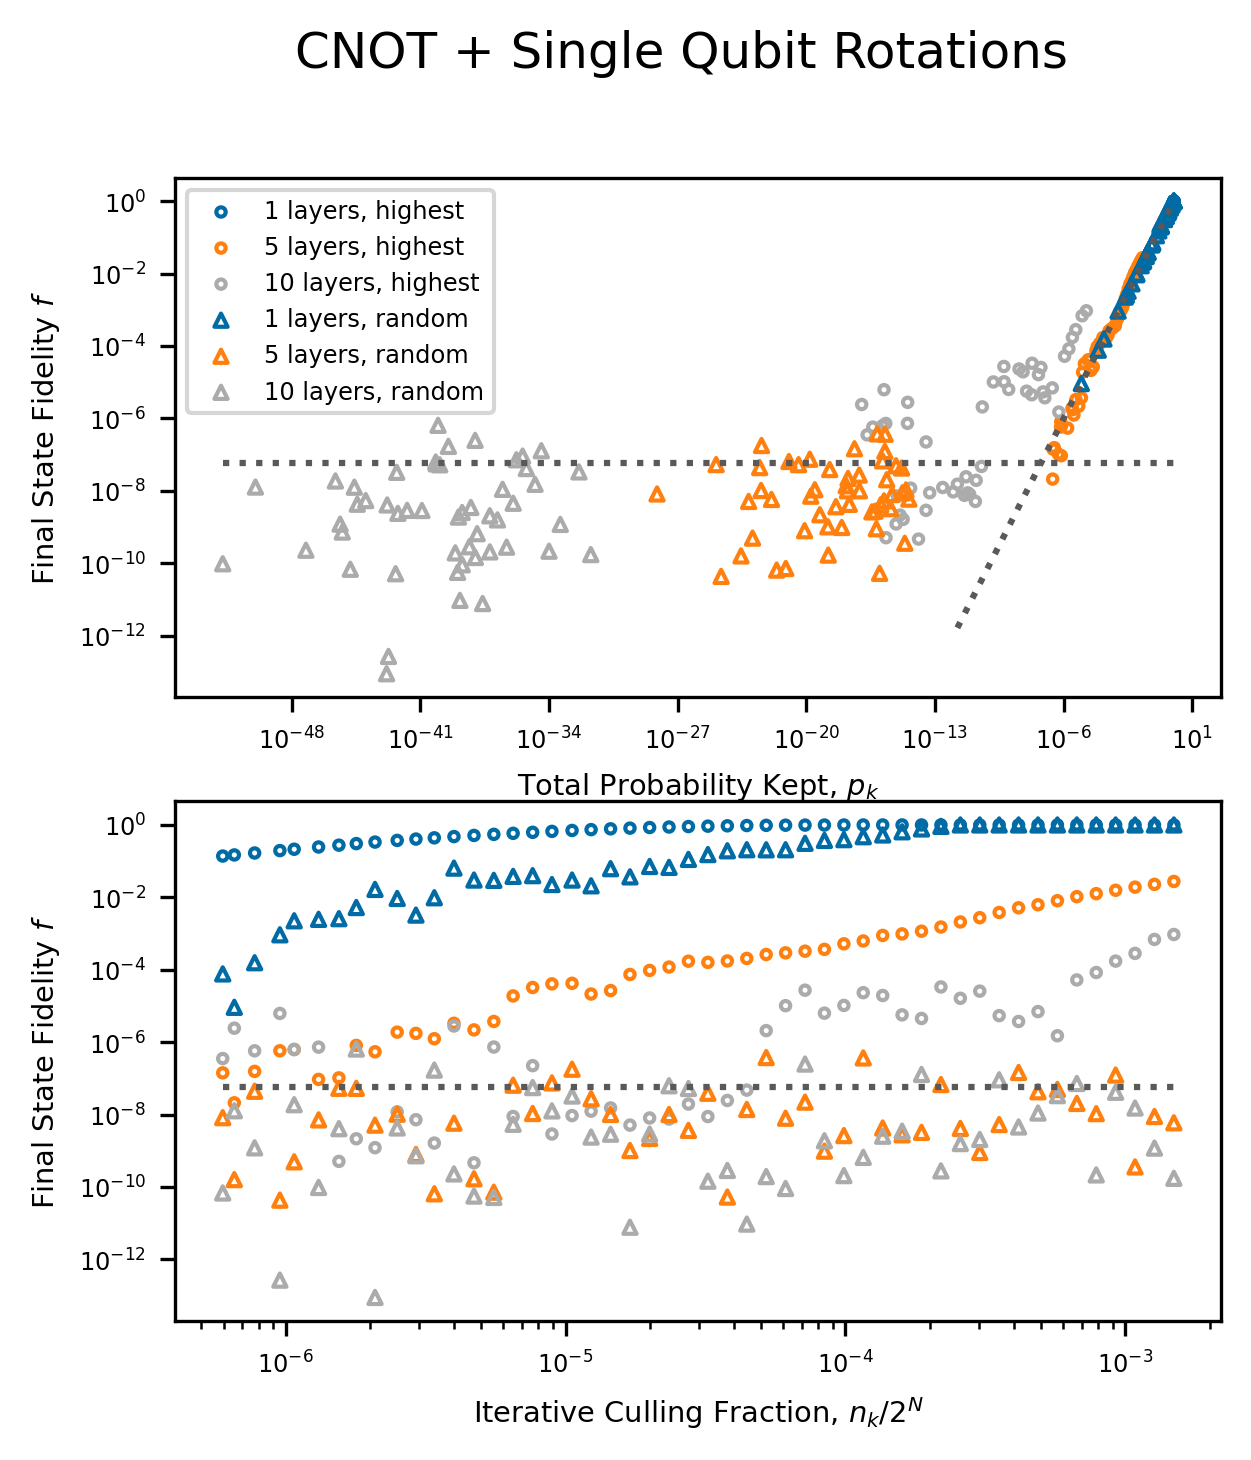

In [35]:
with plt.style.context('tableau-colorblind10'):
    my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

random_params = {'marker':'^', 'facecolors':'none', 's':10}
lowest_params = {'marker':'o', 'facecolors':'none', 's':5}
tick_params = {'labelsize':'xx-small'}
ax_label_args = {'fontsize':'x-small'}
x_label_args = {'position':(10, 100)}
params1 = {'color': my_colors[0]}
params5 = {'color':my_colors[1]}
params10 = {'color':my_colors[2]} 

w =4.5
extra_args = dict(figsize=[w, 1.1*w], dpi=300)
fig, axs = plt.subplots(2,1, **extra_args)#, sharex=True, sharey=True)


# 24 qubits
d1_24_low = load_run_data('results_paper/cnot_24qbit_1layer_lowest.pkl')
d2_24_low = load_run_data('results_paper/cnot_24qbit_5layer_lowest.pkl')
d3_24_low = load_run_data('results_paper/cnot_24qbit_10layer_lowest.pkl')
d1_24_rand = load_run_data('results_paper/cnot_24qbit_1layer_random.pkl')
d2_24_rand = load_run_data('results_paper/cnot_24qbit_5layer_random.pkl')
d3_24_rand = load_run_data('results_paper/cnot_24qbit_10layer_random.pkl')

#lists for unpacking
# d_15_list = [d1_15_low, d2_15_low, d3_15_low , d1_15_rand, d2_15_rand, d3_15_rand]
d_24_list = [d1_24_low, d2_24_low, d3_24_low , d1_24_rand, d2_24_rand, d3_24_rand]

# extract data
n_qbits15 = 15
n_qbits24 = 24

fidelities24 = extract_value(d_24_list, 'fidelity')
probs24 = extract_value(d_24_list, 'total_probability')
n_list24 = extract_value(d_24_list, 'n_kept')
cull_pct_list24 = [n/2**n_qbits24 for n in n_list24]

probs_all = np.sort(np.concatenate(probs24))


# ax 0
axs[1].scatter(cull_pct_list24[0], fidelities24[0], label='1 layers, highest', **lowest_params, **params1)
axs[1].scatter(cull_pct_list24[1], fidelities24[1], label='5 layers, highest', **lowest_params, **params5)
axs[1].scatter(cull_pct_list24[2], fidelities24[2], label='10 layers, highest', **lowest_params, **params10)
axs[1].scatter(cull_pct_list24[3], fidelities24[3], label='1 layers, random', **random_params, **params1)
axs[1].scatter(cull_pct_list24[4], fidelities24[4], label='5 layers, random', **random_params, **params5)
axs[1].scatter(cull_pct_list24[5], fidelities24[5], label='10 layers, random', **random_params, **params10)
axs[1].plot(cull_pct_list24[0], 1/2**n_qbits24*np.ones_like(cull_pct_list24[0]), c=my_colors[3], linestyle=':')
axs[1].set_xlabel('Iterative Culling Fraction, $n_k/2^N$', **ax_label_args, **x_label_args)
axs[1].set_ylabel('Final State Fidelity $f$', **ax_label_args)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].tick_params(**tick_params)

# ax 1
axs[0].scatter(probs24[0], fidelities24[0], label='1 layers, highest', **lowest_params, **params1)
axs[0].scatter(probs24[1], fidelities24[1], label='5 layers, highest', **lowest_params, **params5)
axs[0].scatter(probs24[2], fidelities24[2], label='10 layers, highest', **lowest_params, **params10)
axs[0].scatter(probs24[3], fidelities24[3], label='1 layers, random', **random_params, **params1)
axs[0].scatter(probs24[4], fidelities24[4], label='5 layers, random', **random_params, **params5)
axs[0].scatter(probs24[5], fidelities24[5], label='10 layers, random', **random_params, **params10)
axs[0].plot(probs_all[120:], probs_all[120:], c=my_colors[3], linestyle=':')
axs[0].plot(probs_all, np.ones_like(probs_all)*1/2**n_qbits24, c=my_colors[3], linestyle=':')
axs[0].set_xlabel('Total Probability Kept, $p_k$', **ax_label_args, **x_label_args)
axs[0].set_ylabel('Final State Fidelity $f$', **ax_label_args)
axs[0].tick_params(**tick_params)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend(fontsize='xx-small')

fig.suptitle('CNOT + Single Qubit Rotations')



In [76]:
print(probs24[0], fidelities24[0])

[0.1383275  0.14847416 0.16795793 0.1956491  0.21311029 0.24590026
 0.2766841  0.3051284  0.33634019 0.37379952 0.40707496 0.44053072
 0.47696735 0.51333581 0.54974248 0.58675981 0.62560137 0.66413334
 0.70398008 0.74226453 0.78085681 0.8159921  0.84847353 0.87710545
 0.90250705 0.9257456  0.94595155 0.96260239 0.97483261 0.98376708
 0.99040118 0.99470374 0.99723384 0.99873978 0.99950619 0.99984913
 0.9999679  0.99999708 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ] [0.1383275  0.14847416 0.16795793 0.1956491  0.21311029 0.24590026
 0.2766841  0.3051284  0.33634019 0.37379952 0.40707496 0.44053072
 0.47696735 0.51333581 0.54974248 0.58675981 0.62560137 0.66413334
 0.70398008 0.74226453 0.78085681 0.8159921  0.84847353 0.87710545
 0.90250705 0.9257456  0.94595155 0.96260239 0.97483261 0.98376708
 0.99040118 0.99470374 0.99723384 0.99873978 0.99950619 0.99984913
 0.9999679  0.99999708 1.         1.         1.       

# 4. Higher qubit number with gate reversal

In [ ]:
n_qbits=25

In [ ]:
n_layers = 1

min_paths = 10
max_paths = min(10000, 2**n_qbits)
n_paths_list = np.linspace(min_paths, max_paths, 150, dtype=int)

wires = np.concatenate([construct_random_wire_list(n_qbits) for _ in range(n_layers)])
wires_inv = [w for w in reversed(wires)]
wires_total = np.concatenate([wires, wires_inv])

gates = [haar_2qbit() for _ in wires]
gates_sparse = [convert_gate_to_coo(g) for g in gates]
gates_sparse_inv = [invert_sparse_gate(g) for g in reversed(gates_sparse)]
gates_total = gates_sparse + gates_sparse_inv

total_gates = len(gates)

# # dense circuit
# circuit_dense = quantum_circuit(n_qbits, gates, wires)
# state0_dense = zero_bitstring_np(n_qbits)
# dense_output = circuit_dense.contract(state0_dense)

#initialize results
total_probability_kept = np.zeros_like(n_paths_list, dtype=float)
fidelities = np.zeros_like(total_probability_kept)
fidelities_random = np.zeros_like(fidelities)

# iterate over n_paths
for i, n_paths in enumerate(tqdm(n_paths_list)):
    
    state0 = random_superpos_coo(n_qbits, n_paths)
    #compute circuit output
    fns = [(trim_n_coo(n_paths),1)]
    circuit_sparse = quantum_circuit(n_qbits, gates_total, wires_total)
    sparse_output = circuit_sparse.contract(state0, fns=fns)

    #compute total probability
    total_prob = (np.abs(sparse_output)**2).sum()
    total_probability_kept[i] = total_prob

    #compute_fidelity
    sparse_output.data /= np.sqrt(total_prob) # normalize
    fidelity = np.abs(np.sum(sparse_output * state0))**2
    fidelities[i] = fidelity

    #compute uniform fidelity
    fill_value = 1/2**(n_qbits/2)
    fidelity_random = np.abs(np.sum(sparse_output.data * fill_value))**2
    fidelities_random[i] = fidelity_random

# fidelities, probabilities, n_paths = fidelities.copy(), total_probability_kept.copy(), n_paths_list.copy()

In [ ]:
fig, ax = plt.subplots()

ax.scatter(n_paths_list/2**n_qbits, fidelities, label='1 layer')
print(n_paths_list/2**n_qbits)

val_range = np.linspace(n_paths[0]/2**n_qbits, 1)

ax.plot(val_range, val_range, c='red')
ax.plot(val_range, 1/2**n_qbits*np.ones_like(val_range), c='red', linestyle='--')

ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Cull # / $2^N$')
ax.set_ylabel('final state fidelity, f')
ax.set_title('Fidelity vs Fractional Path Depth')